#### 04 Custom CNN for Pneumonia Detection

**Goal:**  
Train a custom Convolutional Neural Network (CNN) from scratch to classify chest X-ray images as NORMAL or PNEUMONIA.

- Input: Augmented & preprocessed images (via generators)
- Output: Trained CNN model, evaluation metrics, and sample predictions


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns


In [2]:
base_dir = '../chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASSES = ['NORMAL', 'PNEUMONIA']


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


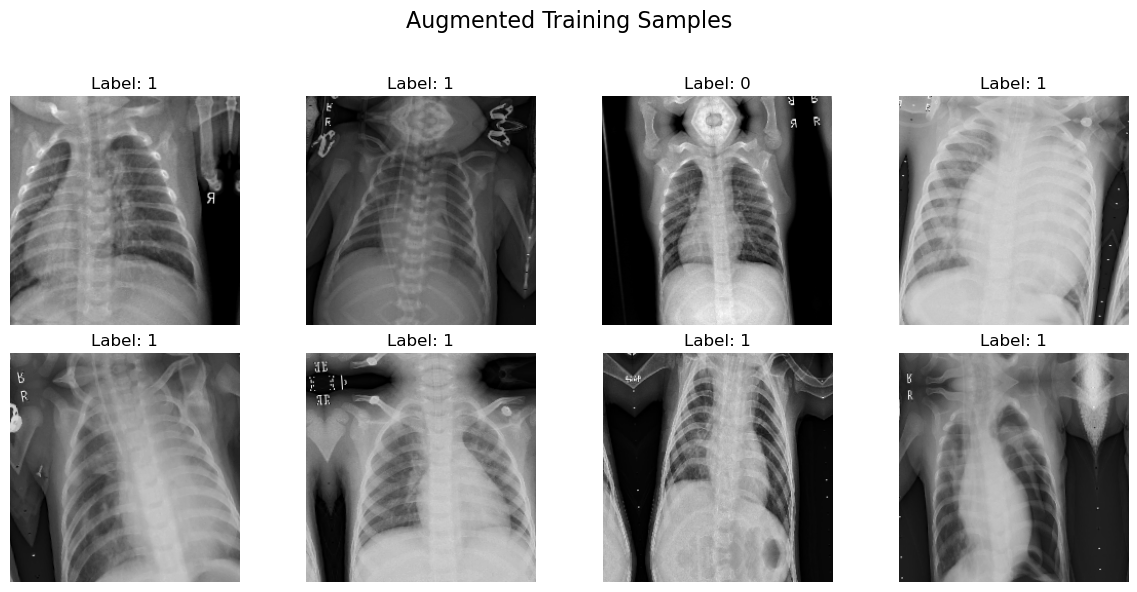

In [4]:
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i].squeeze(), cmap='gray')
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis('off')
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [5]:
def build_custom_cnn(input_shape=(224,224,1)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_custom_cnn((224,224,1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [6]:
EPOCHS = 20

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


Epoch 1/20
163/163 [==============================] - 251s 2s/step - loss: 0.5042 - accuracy: 0.7650 - val_loss: 0.9419 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 358s 2s/step - loss: 0.3336 - accuracy: 0.8457 - val_loss: 0.7913 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 294s 2s/step - loss: 0.2814 - accuracy: 0.8754 - val_loss: 0.4529 - val_accuracy: 0.8125
Epoch 4/20
163/163 [==============================] - 212s 1s/step - loss: 0.2503 - accuracy: 0.8961 - val_loss: 0.7559 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 215s 1s/step - loss: 0.2424 - accuracy: 0.8967 - val_loss: 0.5943 - val_accuracy: 0.8125
Epoch 6/20
163/163 [==============================] - 214s 1s/step - loss: 0.2227 - accuracy: 0.9070 - val_loss: 0.5477 - val_accuracy: 0.8125
Epoch 7/20
163/163 [==============================] - 212s 1s/step - loss: 0.2216 - accuracy: 0.9105 - val_loss: 0.6285 - val_accuracy: 0.8125

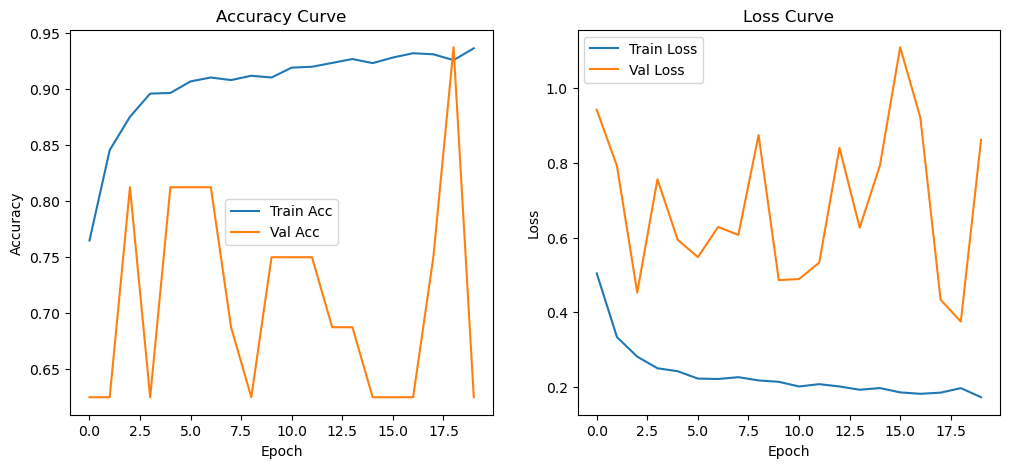

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()


20/20 [==============================] - 15s 681ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.53      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



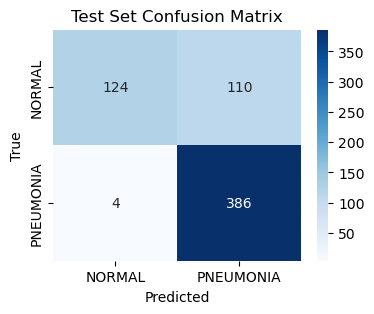

In [12]:
# Get predictions and true labels for test set
test_gen.reset()
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()


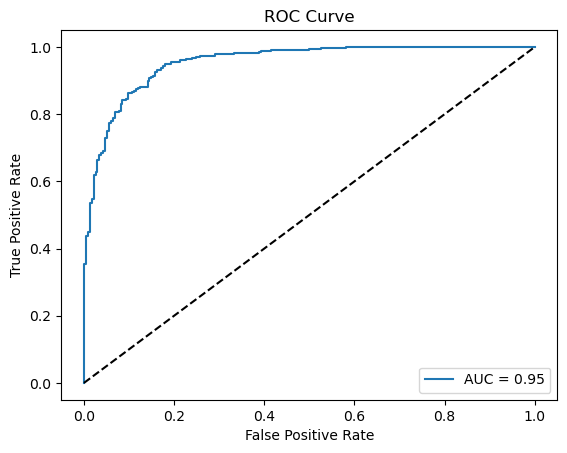

Test AUC: 0.95387902695595


In [9]:
auc = roc_auc_score(y_true, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("Test AUC:", auc)


In [10]:
model.save('saved_models/custom_cnn_pneumonia.h5')
print("Model saved to models/saved/custom_cnn_pneumonia.h5")


c:\Users\Revanth Kumar\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to models/saved/custom_cnn_pneumonia.h5
